# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
  1
  1
  1
 -1
 -1
  1
  1
 -1
  ⋮
  1
 -1
  1
 -1
 -1
 -1
  1
 -1
  1

### We create a function to visualize the data

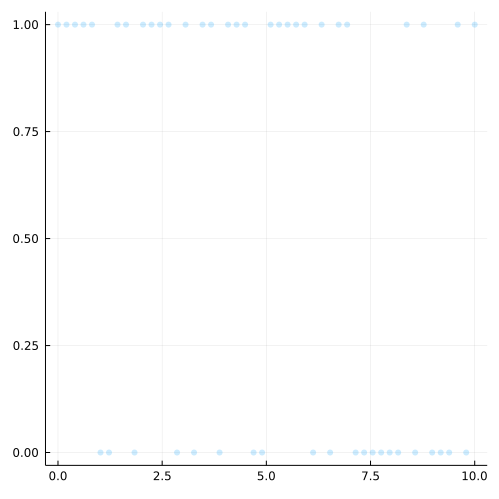

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.984232 seconds (1.86 M allocations: 98.382 MiB, 99.47% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.1479369467847762, 1.1201777259251786, 1.0731110938985051, 1.013973759158459, 0.9527982715449119, 0.8992681747607021, 0.8602233926813092, 0.8380871860376007, 0.8314061888862423, 0.8362280972502805  …  1.0557685155551473, 1.0125035023846447, 0.9505478301138184, 0.8795882166730817, 0.8092552299460636, 0.7481340713398196, 0.7047944676303578, 0.6862734682200438, 0.6954533036107253, 0.72852642994943], θ = [0.22573878370145745, 0.22676908799023812, 0.22848343559352668, 0.23057509895123066, 0.23265951598025045, 0.23441181953942705, 0.23564498139622111, 0.23632648929775987, 0.23652960679761575, 0.23638313057117416  …  0.2291042681149007, 0.23062616794224905, 0.23273456708734763, 0.23503825800028844, 0.23719435909912645, 0.2389571517327369, 0.24014080221260714, 0.24062919052056558, 0.2403884494

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:20
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:43
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:48
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:21
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:04
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:46
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:40
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:26
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[1.8771681869293153, 2.0207956440731145, 2.0118913126527582, 1.8518596396682572, 1.6786507996854159, 1.485013213611075, 1.3521653301322663, 1.2902728812085282, 1.2566098991933121, 1.2368787457856545  …  -0.14589429114186547, -0.23412371714093494, -0.368801137844058, -0.478189311169311, -0.5714744447247021, -0.6249586156444622, -0.649961569037277, -0.6700558588177401, -0.6981815406662499, -0.7854356844357284]]
 [[0.21347683409806628, 0.3752395785802598, 0.42101416228264643, 0.385968341919799, 0.2619172647544691, 0.12474261217642268, -0.05074158158071629, -0.17849557481254863, -0.2910614457699041, -0.3099978381173141  …  -0.49868745475636483, -0.4589530762171865, -0.4794550775364939, -0.5721927565746772, -0.7055720665142275, -0.8613112732777195, -1.0067162166984254, -1.0588771221077633, -1.098833765477389, -1.0256251814791488]]
 [[1.1470768786648389, 1.3094815745116886, 1.4275615784336835, 1.4460204708494966, 1.3631899051322804, 1.171763070

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

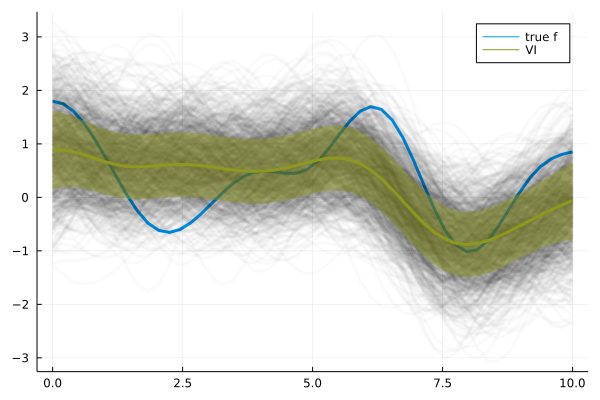

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

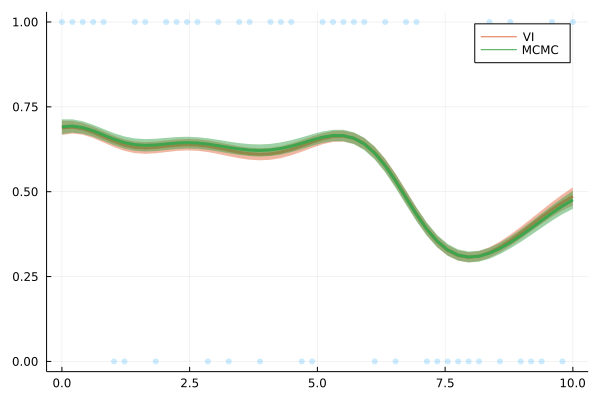

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*